In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import plotly.subplots as sp
import plotly.graph_objects as go
import scipy.stats as sts
import statsmodels.graphics.gofplots as sm
import matplotlib.backends.backend_pdf as pdf_backend

df = pd.read_excel("BakeryData_Vilnius.xlsx")
#stores = ["main street A","main street B","station A","station B"]
stores = ["main street A","station A"]
daysOfTheWeek = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["weekday_text"] = df['date'].dt.strftime('%A')
df["date"] = pd.to_datetime(df["date"]).dt.date
df

,date,weekday,main street A,main street B,station A,station B,weekday_text
0,2016-05-11,3,2.23,NaN,NaN,NaN,Wednesday
1,2016-05-12,4,18.10,NaN,NaN,NaN,Thursday
2,2016-05-13,5,15.85,NaN,NaN,NaN,Friday
3,2016-05-14,6,14.22,NaN,NaN,NaN,Saturday
4,2016-05-15,7,2.58,NaN,NaN,NaN,Sunday
...,...,...,...,...,...,...,...
2572,2023-05-27,6,168.05,32.34,76.97,114.30,Saturday
2573,2023-05-28,7,44.62,32.85,80.21,91.25,Sunday
2574,2023-05-29,1,64.11,116.84,149.75,92.56,Monday
2575,2023-05-30,2,103.63,134.48,194.03,75.63,Tuesday


Data cleaning step, we remove data from before 2017, data from the covid period and outliers.

In [36]:
begin = datetime(day = 31,month = 12,year = 2016).date()
pre_covid = datetime(day = 1,month = 3,year = 2021).date()
after_covid = datetime(day = 1,month = 3,year = 2022).date()
df = df[((df["date"] < pre_covid) | (df["date"] > after_covid)) & (df["date"] > begin)]

def removeOutliers(df):
    mean = df.mean()
    sd = df.std()
    return df[(df > (mean - 3*sd)) & (df < (mean + 3*sd))]


Jarque–Bera function Testing method for normality

In [37]:
def jarqueBera(alpha, stores, dist):
    table = []
    for store in stores:
        for day in daysOfTheWeek:
            if dist == 'lognorm':
                data = np.log(removeOutliers(df[df["weekday_text"] == day][store].dropna()))
            else:
                data = removeOutliers(df[df["weekday_text"] == day][store].dropna())
            jarque_bera_test = sts.jarque_bera(data)
            
            n = len(data)
            criticalValue = sts.chi2.ppf(1-alpha, df=2)
            if n*(pow(sts.skew(data), 2)/6 + pow(sts.kurtosis(data, fisher=False)-3, 2)/24) >= criticalValue:
                JB_2 = "JB test rejects normality"
            else:
                JB_2 = "JB test fails to reject normality"

            table.append([store,day,jarque_bera_test.pvalue,JB_2])

    return pd.DataFrame(table, columns=["store","day","p-value","second JB"])


QQ-Plots for the normal distribution

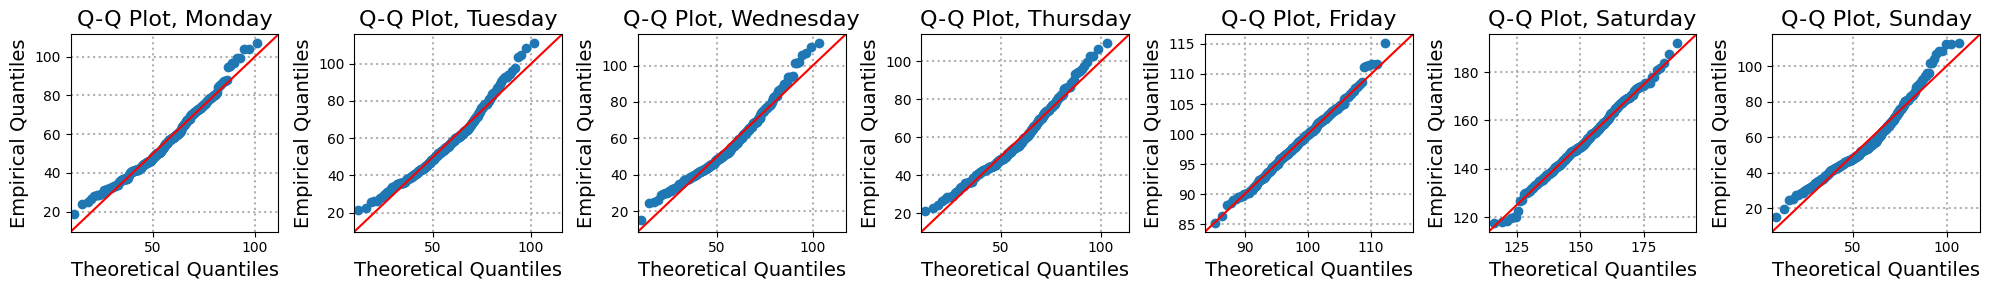

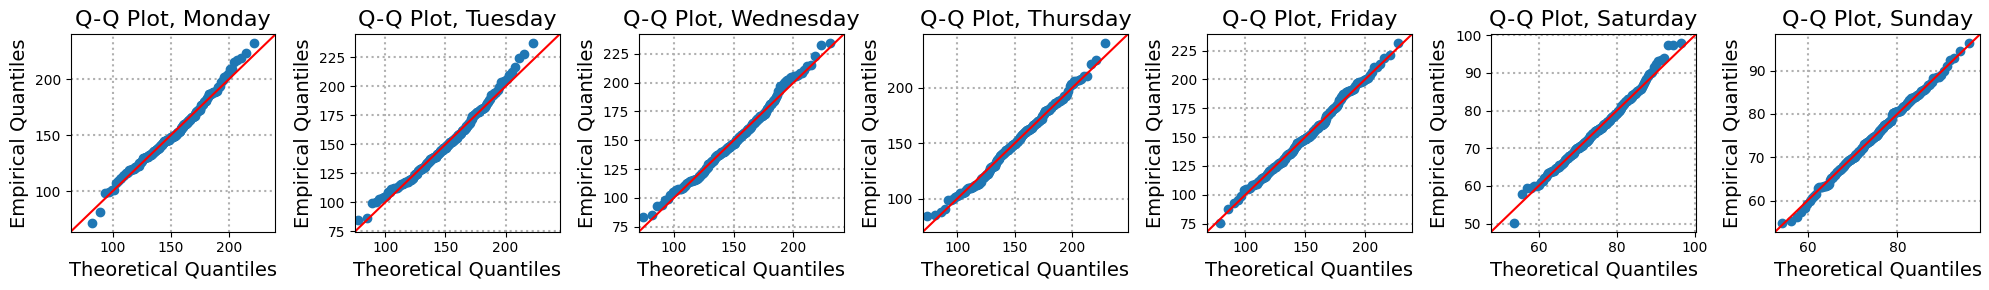

,store,day,p-value,second JB
0,main street A,Monday,1.909732e-03,JB test rejects normality
1,main street A,Tuesday,6.524743e-05,JB test rejects normality
2,main street A,Wednesday,4.775973e-06,JB test rejects normality
3,main street A,Thursday,7.073962e-04,JB test rejects normality
4,main street A,Friday,5.723344e-01,JB test fails to reject normality
5,main street A,Saturday,9.341964e-01,JB test fails to reject normality
6,main street A,Sunday,4.448163e-07,JB test rejects normality
7,station A,Monday,1.509971e-01,JB test fails to reject normality
8,station A,Tuesday,3.772753e-02,JB test rejects normality
9,station A,Wednesday,1.691909e-01,JB test fails to reject normality


In [38]:
fig, axs = plt.subplots(1, 7, figsize=(20, 3))  # Adjust the figsize as per your preference
for store in stores:
    #pdf = pdf_backend.PdfPages("Excercise part 6/{0}-qqplot-norm.pdf".format(store))
    for i, day in enumerate(daysOfTheWeek):
        data = removeOutliers(df[df["weekday_text"] == day][store].dropna())
        plt.sca(axs[i])
        axs[i].cla()

        [me,ve,se,ke] = [sts.describe(data).mean, sts.describe(data).variance,sts.describe(data).skewness,sts.describe(data).kurtosis]       
        sm.qqplot(data, sts.norm(loc=me, scale=np.sqrt(ve)), line='45',ax=axs[i])

        #plt.title("{0}".format(day))
        plt.title('Q-Q Plot, {0}'.format(day), fontsize=16)
        plt.xlabel('Theoretical Quantiles',fontsize=14)
        plt.ylabel('Empirical Quantiles',fontsize=14)
        plt.grid(True,linewidth=1.5,linestyle=':')
        plt.tight_layout()
    #pdf.savefig(fig)
    #pdf.close()
    plt.show()

jarqueBera(0.05,stores, "norm")

QQ-plots for the lognormal distribution

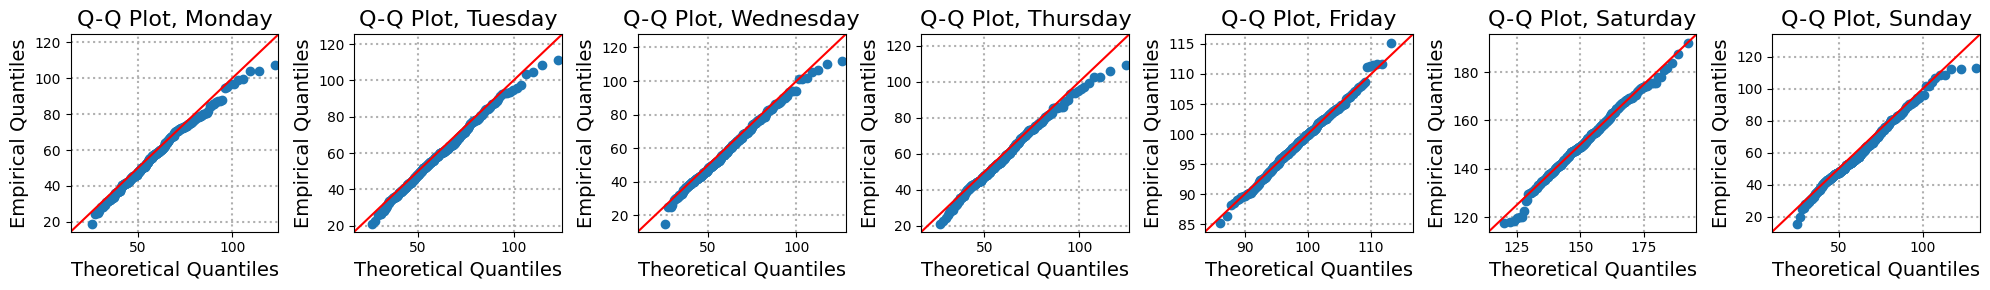

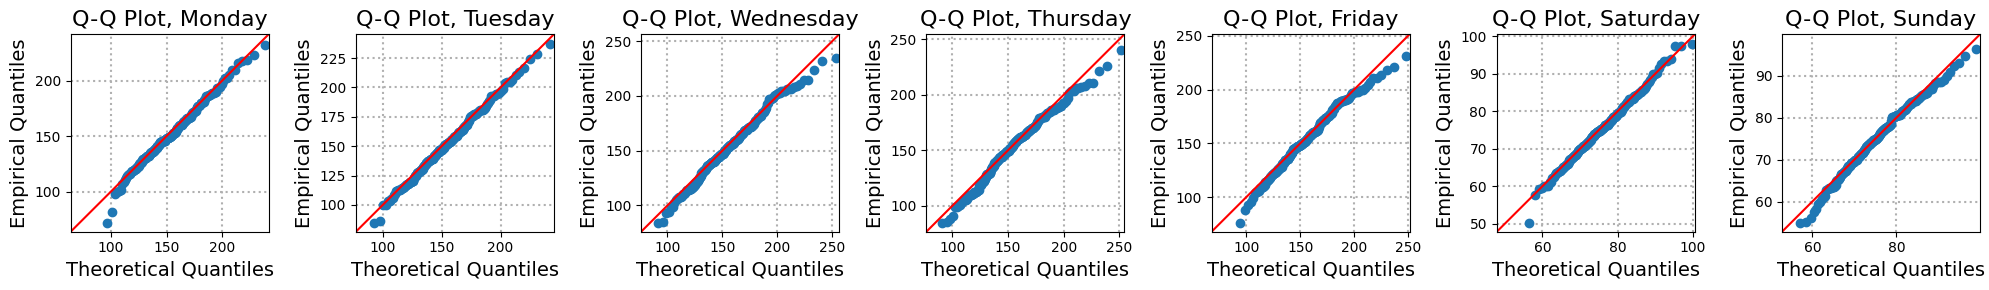

,store,day,p-value,second JB
0,main street A,Monday,0.215500,JB test fails to reject normality
1,main street A,Tuesday,0.403298,JB test fails to reject normality
2,main street A,Wednesday,0.057162,JB test fails to reject normality
3,main street A,Thursday,0.255126,JB test fails to reject normality
4,main street A,Friday,0.995478,JB test fails to reject normality
5,main street A,Saturday,0.320424,JB test fails to reject normality
6,main street A,Sunday,0.014348,JB test rejects normality
7,station A,Monday,0.000380,JB test rejects normality
8,station A,Tuesday,0.886846,JB test fails to reject normality
9,station A,Wednesday,0.412680,JB test fails to reject normality


In [39]:
fig, axs = plt.subplots(1, 7, figsize=(20, 3))  # Adjust the figsize as per your preference
for store in stores:
    #pdf = pdf_backend.PdfPages("Excercise part 6/{0}-qqplot-lognorm.pdf".format(store))
    for i, day in enumerate(daysOfTheWeek):
        data = removeOutliers(df[df["weekday_text"] == day][store].dropna())
        plt.sca(axs[i])
        axs[i].cla()

        [me, ve, se, ke] = [sts.describe(data).mean, sts.describe(data).variance, sts.describe(data).skewness, sts.describe(data).kurtosis]       
        lognorm_dist = sts.lognorm(s=np.sqrt(np.log(1 + ve / (me ** 2))), scale=me)
        sm.qqplot(data, lognorm_dist, line='45', ax=axs[i])

        plt.title('Q-Q Plot, {0}'.format(day), fontsize=16)
        plt.xlabel('Theoretical Quantiles', fontsize=14)
        plt.ylabel('Empirical Quantiles', fontsize=14)
        plt.grid(True, linewidth=1.5, linestyle=':')
        plt.tight_layout()
    #pdf.savefig(fig)
    #pdf.close()
    plt.show()

jarqueBera(0.05,stores, "lognorm")